# Fine tuning with S-BERT

The models will be saved in this folder - https://drive.google.com/drive/folders/1ui5rywdrDdbBUeHph9AaA0VpfX01bbRe?usp=sharing


# Setup

In [ ]:
# Install necessary libraries
! pip install --quiet \
  scprep\
  spacy==3.0.5 \
  wandb \
  onnx \
  onnxruntime \
  sentence_transformers==1.0.2 \
  phate==1.0.7 && \
  python -m spacy download es_core_news_lg

# Restarting the runtime is required for the libraries to be active in the notebook
import os
os.kill(os.getpid(), 9)

     |████████████████████████████████| 112kB 13.7MB/s 
     |████████████████████████████████| 12.8MB 15.0MB/s 
     |████████████████████████████████| 2.1MB 53.6MB/s 
     |████████████████████████████████| 12.2MB 199kB/s 
     |████████████████████████████████| 4.1MB 51.9MB/s 
     |████████████████████████████████| 81kB 10.5MB/s 
     |████████████████████████████████| 51kB 7.7MB/s 
     |████████████████████████████████| 1.1MB 36.2MB/s 
     |████████████████████████████████| 460kB 53.1MB/s 
     |████████████████████████████████| 9.1MB 44.0MB/s 
     |████████████████████████████████| 102kB 13.1MB/s 
     |████████████████████████████████| 163kB 50.4MB/s 
     |████████████████████████████████| 133kB 55.4MB/s 
     |████████████████████████████████| 2.1MB 43.6MB/s 
     |████████████████████████████████| 1.2MB 44.5MB/s 
     |████████████████████████████████| 51kB 7.8MB/s 
     |████████████████████████████████| 419kB 56.7MB/s 
     |████████████████████████████████| 122kB 57.8MB

In [1]:
# Setup connection with your own google drive
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [6]:
# Clone branch from github
!rm -rf policy-data-analyzer/
! branch_name='wandb-experiments-jordi' && \
  git clone --branch $branch_name https://github.com/wri-dssg/policy-data-analyzer.git

Cloning into 'policy-data-analyzer'...
remote: Enumerating objects: 5964, done.
remote: Counting objects: 100% (705/705), done.
remote: Compressing objects: 100% (272/272), done.
remote: Total 5964 (delta 454), reused 673 (delta 430), pack-reused 5259
Receiving objects: 100% (5964/5964), 206.32 MiB | 25.01 MiB/s, done.
Resolving deltas: 100% (3217/3217), done.
Checking out files: 100% (1004/1004), done.


In [7]:
#If you run this cell more than once, comment out this line because you are already in this folder and you will get an error
import os
# os.chdir("policy-data-analyzer") 

from tasks.fine_tuning_sbert.src.loops import *

SyntaxError: ignored

In [24]:
import os
import math
import random
import wandb
import time
from pathlib import Path
from typing import Iterable, Dict

import cupy as cp
import spacy
import onnx
import transformers
import multiprocessing
import onnxruntime as rt
import torch
from transformers import convert_graph_to_onnx
from sentence_transformers import SentencesDataset, SentenceTransformer, InputExample
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from torch import nn, Tensor
from torch.utils.data import DataLoader

from tasks.data_augmentation.src.zero_shot_classification.latent_embeddings_classifier import *
from tasks.data_loading.src.utils import *
from tasks.data_visualization.src.plotting import *
from tasks.fine_tuning_sbert.src.sentence_transformer import EarlyStoppingSentenceTransformer
from tasks.fine_tuning_sbert.src.custom_evaluator import CustomLabelAccuracyEvaluator
from tasks.model_evaluation.src.model_evaluator import *

if spacy.prefer_gpu():
    print("Using the GPU")
else:
    print("Using the CPU")

#  May need to run python -m spacy download es_core_news_lg first!
es_nlp = spacy.load('es_core_news_lg')


class SoftmaxClassifier(nn.Module):
    """
    This loss adds a softmax classifier on top of the output of the transformer network.
    It takes a sentence embedding and learns a mapping between it and the corresponding category.
    :param model: SentenceTransformer model
    :param sentence_embedding_dimension: Dimension of your sentence embeddings
    :param num_labels: Number of different labels
    """

    def __init__(self,
                 model: SentenceTransformer,
                 sentence_embedding_dimension: int,
                 num_labels: int):
        super(SoftmaxClassifier, self).__init__()
        self.model = model
        self.num_labels = num_labels
        self.classifier = nn.Linear(sentence_embedding_dimension, num_labels)

    def forward(self, sentence_features: Iterable[Dict[str, Tensor]], labels: Tensor):
        # Get batch sentence embeddings
        features = self.model(sentence_features[0])['sentence_embedding']

        # Get batch loss
        output = self.classifier(features)
        loss_fct = nn.CrossEntropyLoss()

        if labels is not None:
            loss = loss_fct(output, labels.view(-1))
            return loss
        else:
            return features, output


def grid_search_fine_tune_sbert(train_params, train_sents, train_labels, test_sents, test_labels, label_names,
                                eval_classifier=None):
    """
    Find the optimal SBERT model by doing a hyperparameter search over random seeds, dev percentage, and different types of SBERT models
    """
    output_path = train_params["output_path"]
    all_dev_perc = train_params["all_dev_perc"]
    model_names = train_params["model_names"]
    max_num_epochs = train_params["max_num_epochs"]
    baseline = train_params['baseline']
    patience = train_params['patience']
    nReplicas = train_params['replicas']
    warmUpSteps = train_params['warmup']
    wandb_key = train_params['wandb_key']
    # seeds = train_params['seeds']

    os.environ['WANDB_API_KEY'] = wandb_key

    if eval_classifier is None:
        train_params["eval_classifier"] = "SBERT"
    else:
        train_params["eval_classifier"] = eval_classifier.__class__.__name__

    print(
        f"Grid Search Fine tuning parameters:\n{json.dumps(train_params, indent=4)}")

    label2int = dict(zip(label_names, range(len(label_names))))

    for dev_perc in all_dev_perc:
        # split the labelled data set into train an development sets
        X_train, X_dev, y_train, y_dev = train_test_split(train_sents, train_labels, test_size=dev_perc,
                                                          stratify=train_labels, random_state=100)
        # split again the labelled data set to get a validation set which will be used for classifiation performance
        X_train_, X_val, y_train_, y_val = train_test_split(train_sents, train_labels, test_size=dev_perc,
                                                          stratify=train_labels, random_state=10)

        # Load data samples into batches
        train_batch_size = 16
        train_samples = build_data_samples(X_train, label2int, y_train)
        dev_samples = build_data_samples(X_dev, label2int, y_dev)

        # Loop to test several warm up steps. the "wup" variable is the factor by which "len(train_dataset)"" is multiplied
        for wup in warmUpSteps:

            # Loop to run the model training process several times to explore the optimization landscape
            for rep in range(1, nReplicas[0] + 1):
                for model_name in model_names:
                    # Train set config
                    model = EarlyStoppingSentenceTransformer(model_name)
                    train_dataset = SentencesDataset(train_samples, model=model)
                    train_dataloader = DataLoader(
                        train_dataset, shuffle=True, batch_size=train_batch_size)

                    # Dev set config
                    dev_dataset = SentencesDataset(dev_samples, model=model)
                    dev_dataloader = DataLoader(
                        dev_dataset, shuffle=True, batch_size=train_batch_size)

                    # Define the way the loss is computed
                    classifier = SoftmaxClassifier(model=model,
                                                sentence_embedding_dimension=model.get_sentence_embedding_dimension(),
                                                num_labels=len(label2int))
                    warmup_steps = math.ceil(
                        len(train_dataset) * wup) #max_num_epochs / train_batch_size * 0.1)  # 10% of train data for warm-up

                    model_deets = f"{train_params['eval_classifier']}_model={model_name}_test-perc={dev_perc}_warmup={wup}_replica={rep}"

                    # Train the model
                    start = time.time()
                    dev_evaluator = CustomLabelAccuracyEvaluator(dataloader=dev_dataloader, softmax_model=classifier,
                                                                name='lae-dev', label_names=label_names,
                                                                model_hyper_params={'model_name': model_name, 'dev_perc': dev_perc, 
                                                                'warmup_steps': warmup_steps, 'replica' :rep})

                    # this will write to the same project every time
                    wandb.init(name=model_deets, project='WRI', tags=['baseline', 'training'],
                            entity='ramanshsharma')

                    wandb.watch(model, log='all')

                    model.fit(train_objectives=[(train_dataloader, classifier)],
                            evaluator=dev_evaluator,
                            epochs=max_num_epochs,
                            evaluation_steps=1000,
                            warmup_steps=warmup_steps,
                            output_path=output_path,
                            model_deets=model_deets,
                            baseline=baseline,
                            patience=patience,
                            )
                    clf = RandomForestClassifier(n_estimators=500,
                            max_features=0.06,
                            n_jobs=6,
                            random_state=69420)
                    # We use the validation set to evaluate the performance using random forest
                    model_deets_val = model_deets + "_validation_data"
                    evaluate_using_sklearn(clf, model, train_sents, train_labels, X_val, y_val,
                           label_names, model_deets, output_path, testing = True)
                    # We use the test set to evaluate the performance using random forest
                    model_deets_test = model_deets + "_test_data"
                    evaluate_using_sklearn(clf, model, train_sents, train_labels, test_sents, test_labels,
                           label_names, model_deets, output_path, testing = True)
                    
                    print(model_deets)
                    end = time.time()
                    hours, rem = divmod(end - start, 3600)
                    minutes, seconds = divmod(rem, 60)
                    print("Time taken for fine-tuning:",
                      "{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

                wandb.save(output_path)
                wandb.finish()

                end = time.time()
                hours, rem = divmod(end - start, 3600)
                minutes, seconds = divmod(rem, 60)
                print("Time taken for fine-tuning:",
                      "{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))


def build_data_samples(X_train, label2int, y_train):
    train_samples = []
    for sent, label in zip(X_train, y_train):
        label_id = label2int[label]
        train_samples.append(InputExample(texts=[sent], label=label_id))
    return train_samples


# def set_seeds(seed):
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     # Torch RNG
#     torch.manual_seed(seed)
#     # torch.cuda.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)
#     # Python RNG
#     np.random.seed(seed)
#     random.seed(seed)
#     # CuDA Determinism
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     torch.backends.cudnn.enabled = False


def evaluate_using_sbert(model, test_sents, test_labels, label_names,
                         model_deets, numeric_labels, output_path=None, testing=False):
    """
    Evaluate an S-BERT model on a previously unseen test set, visualizing the embeddings, confusion matrix,
    and returning. Evaluation method:
     - Calculate cosine similarity between label and sentence embeddings
     - Includes the projection matrix approach used in https://joeddav.github.io/blog/2020/05/29/ZSL.html#A-latent-embedding-approach

    """
    # Projection matrix Z low-dim projection
    print("Classifying sentences...")
    proj_matrix = cp.asnumpy(calc_proj_matrix(
        test_sents, 50, es_nlp, model, 0.01))
    test_embs = encode_all_sents(test_sents, model, proj_matrix)
    label_embs = encode_labels(label_names, model, proj_matrix)

    model_preds, model_scores = calc_all_cos_similarity(
        test_embs, label_embs, label_names)

    print("Evaluating predictions...")
    print(classification_report(test_labels, model_preds))
    numeric_preds = labels2numeric(model_preds, label_names)
    evaluator = ModelEvaluator(
        label_names, y_true=numeric_labels, y_pred=numeric_preds)

    print("Visualizing...")
    out_path = f"{output_path}/{model_deets}" if output_path and model_deets else None
    if not testing:
        visualize_embeddings_2D(np.vstack(test_embs), test_labels, tsne_perplexity=50,
                                output_path=out_path)
        evaluator.plot_confusion_matrix(
            color_map='Blues', output_path=out_path)
    print("Macro/Weighted Avg F1-score:", evaluator.avg_f1.tolist())

    return evaluator.avg_f1.tolist()


def evaluate_using_sklearn(clf, model, train_sents, train_labels, test_sents, test_labels,
                           label_names, model_deets, output_path=None, testing=False):
    """
    Evaluate an S-BERT model on a previously unseen test set, visualizing the embeddings, confusion matrix,
    and returning. Evaluation method:
     - A sklearn classifier, such as a RandomForest or SVM
    """
    # Sentence encoding
    print("Classifying sentences...")
    train_embs = encode_all_sents(train_sents, model)
    test_embs = encode_all_sents(test_sents, model)

    # Classifier training
    clf.fit(np.vstack(train_embs), train_labels)

    # Classifier predictions
    clf_preds = list(clf.predict(np.vstack(test_embs)))

    print("Evaluating predictions...")
    print(classification_report(test_labels, clf_preds))
    numeric_preds = labels2numeric(clf_preds, label_names)
    numeric_test_labels = labels2numeric(test_labels, label_names)
    evaluator = ModelEvaluator(
        label_names, y_true=numeric_test_labels, y_pred=numeric_preds)

    print("Visualizing...")
    out_path = f"{output_path}/{model_deets}" if output_path and model_deets else None
    if not testing:
        visualize_embeddings_2D(np.vstack(test_embs), test_labels, tsne_perplexity=50,
                                output_path=out_path)
        evaluator.plot_confusion_matrix(color_map='Blues', output_path=out_path)
    print("Macro/Weighted Avg F1-score:", evaluator.avg_f1.tolist())

    return evaluator.avg_f1.tolist()

Using the GPU


# Data Loading

In [12]:
"""
MAKE SURE THAT THIS IS ALWAYS YOUR INDIVIDUAL NUMBER (FOR REASONS TO NOT OVERWRITE DATA)
"""

GLOBAL_EXPERIMENT_NUMBER = 12

Please do not overwrite existing models and their results from previous experiments
You are writing to Experiment # 12


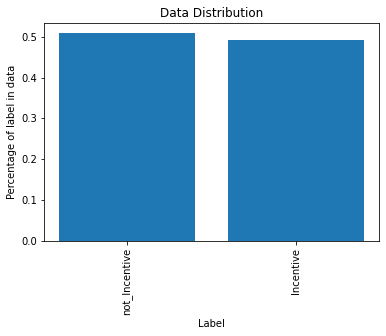

Label counts:
{'not_Incentive': 0.5081127241673783, 'Incentive': 0.4918872758326217}


In [13]:
experiment = "EXP26"
classifier = "Binary"

base_path = "/content/drive/MyDrive/Official Folder of WRI Latin America Project/WRI-LatinAmerica-Talent"

data_path = f"{base_path}/Cristina_Policy_Files/Tagged_sentence_lists/Spanish/datasets/{classifier}"

results_save_path = f"{base_path}/Modeling/Model_reproducibility/Model_results/{classifier}ClassificationExperiments/{GLOBAL_EXPERIMENT_NUMBER}"

if not os.path.exists(results_save_path):
    os.makedirs(results_save_path)
    print(f"Making new experiment folder for experiment # {GLOBAL_EXPERIMENT_NUMBER}")
else:
    print("Please do not overwrite existing models and their results from previous experiments")
    print(f"You are writing to Experiment # {GLOBAL_EXPERIMENT_NUMBER}")

train_sents, train_labels, test_sents, test_labels = load_dataset(data_path, experiment)
label_names = unique_labels(train_labels)
numeric_train_labels = labels2numeric(train_labels, label_names)

plot_data_distribution(numeric_train_labels, label_names)

# Grid Search Fine Tuning

Stores only the parameters used in the grid search, together with the results - no model is stored

In [18]:
# PASTE YOUR WEIGHTS & BIASES KEY HERE
filename = "/content/drive/MyDrive/claus/WandB_Jordi.txt"
with open(filename, "r") as f:
  wandb_key = f.read().rstrip()

In [25]:
grid_search_params = {
    "all_dev_perc": [0.20],# 0.15, 0.25, 0.3],
    "model_names": ['paraphrase-xlm-r-multilingual-v1'], #'stsb-xlm-r-multilingual', 'quora-distilbert-multilingual''distiluse-base-multilingual-sed-v2',
    "output_path": results_save_path,
    "max_num_epochs": 10,
    "baseline": 0.001,
    "patience": 5,
    "replicas": [10],
    "warmup" : [0.01, 0.03, 0.05, 0.07, 0.09],
    "wandb_key": wandb_key
}

grid_search_fine_tune_sbert(grid_search_params, train_sents, train_labels, test_sents, test_labels, label_names)

Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.65it/s]


Current Score is: 0.8571428571428571
Current ACC_LIST is: [1e-06, 0.8571428571428571]
Epoch: 0
Best score: 0.8571428571428571


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.80it/s]


Current Score is: 0.8720682302771855
Current ACC_LIST is: [0.8571428571428571, 0.8720682302771855]
Epoch: 1
Best score: 0.8720682302771855


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.46it/s]


Current Score is: 0.8955223880597015
Current ACC_LIST is: [0.8571428571428571, 0.8720682302771855, 0.8955223880597015]
Epoch: 2
Best score: 0.8955223880597015


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.75it/s]


Current Score is: 0.8528784648187633
Current ACC_LIST is: [0.8571428571428571, 0.8720682302771855, 0.8955223880597015, 0.8528784648187633]
Epoch: 3
Best score: 0.8955223880597015


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.01it/s]


Current Score is: 0.8869936034115139
Current ACC_LIST is: [0.8571428571428571, 0.8720682302771855, 0.8955223880597015, 0.8528784648187633, 0.8869936034115139]
Epoch: 4
Best score: 0.8955223880597015


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.14it/s]


Current Score is: 0.8720682302771855
Current ACC_LIST is: [0.8571428571428571, 0.8720682302771855, 0.8955223880597015, 0.8528784648187633, 0.8869936034115139, 0.8720682302771855]
Epoch: 5
Best score: 0.8955223880597015


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.71it/s]


Current Score is: 0.8891257995735607
Current ACC_LIST is: [0.8571428571428571, 0.8720682302771855, 0.8955223880597015, 0.8528784648187633, 0.8869936034115139, 0.8720682302771855, 0.8891257995735607]
Epoch: 6
Best score: 0.8955223880597015


  0%|          | 3/2342 [00:00<01:21, 28.54it/s]

Current Score is: 0.8891257995735607
Current ACC_LIST is: [0.8571428571428571, 0.8720682302771855, 0.8955223880597015, 0.8528784648187633, 0.8869936034115139, 0.8720682302771855, 0.8891257995735607, 0.8891257995735607]
TRAINING EXITED. Best model has been found.
Epoch: 7
Best score: 0.8955223880597015
Classifying sentences...


  0%|          | 6/2342 [00:00<00:39, 58.59it/s]

Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       1.00      1.00      1.00       231
not_Incentive       1.00      1.00      1.00       238

     accuracy                           1.00       469
    macro avg       1.00      1.00      1.00       469
 weighted avg       1.00      1.00      1.00       469

Visualizing...
Macro/Weighted Avg F1-score: [1.0, 1.0]
Classifying sentences...


100%|██████████| 586/586 [00:09<00:00, 59.86it/s]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.90      0.89      0.90       288
not_Incentive       0.90      0.90      0.90       298

     accuracy                           0.90       586
    macro avg       0.90      0.90      0.90       586
 weighted avg       0.90      0.90      0.90       586

Visualizing...
Macro/Weighted Avg F1-score: [0.8975679675573631, 0.8976037625109827]


train_acc,0.99947
epoch,7
_runtime,210
_timestamp,1619360086
_step,39
validation_acc,0.88913
Macro F1 validation,0.88913
Weighted F1 validation,0.88913


train_acc,▁▄▇▇████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_acc,▂▄█▁▇▄▇▇
Macro F1 validation,▂▄█▁▇▄▇▇
Weighted F1 validation,▂▄█▁▇▄▇▇


Time taken for fine-tuning: 00:05:54.48


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 31.04it/s]


Current Score is: 0.8486140724946695
Current ACC_LIST is: [1e-06, 0.8486140724946695]
Epoch: 0
Best score: 0.8486140724946695


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.89it/s]


Current Score is: 0.9019189765458422
Current ACC_LIST is: [0.8486140724946695, 0.9019189765458422]
Epoch: 1
Best score: 0.9019189765458422


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.47it/s]


Current Score is: 0.8997867803837953
Current ACC_LIST is: [0.8486140724946695, 0.9019189765458422, 0.8997867803837953]
Epoch: 2
Best score: 0.9019189765458422


  0%|          | 3/2342 [00:00<01:21, 28.59it/s]

Current Score is: 0.8997867803837953
Current ACC_LIST is: [0.8486140724946695, 0.9019189765458422, 0.8997867803837953, 0.8997867803837953]
TRAINING EXITED. Best model has been found.
Epoch: 3
Best score: 0.9019189765458422
Classifying sentences...


  0%|          | 7/2342 [00:00<00:38, 61.20it/s]

Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       1.00      1.00      1.00       231
not_Incentive       1.00      1.00      1.00       238

     accuracy                           1.00       469
    macro avg       1.00      1.00      1.00       469
 weighted avg       1.00      1.00      1.00       469

Visualizing...
Macro/Weighted Avg F1-score: [1.0, 1.0]
Classifying sentences...


100%|██████████| 586/586 [00:09<00:00, 59.45it/s]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.89      0.89      0.89       288
not_Incentive       0.89      0.90      0.89       298

     accuracy                           0.89       586
    macro avg       0.89      0.89      0.89       586
 weighted avg       0.89      0.89      0.89       586

Visualizing...
Macro/Weighted Avg F1-score: [0.8924535722088704, 0.8924880225433443]


train_acc,0.99253
epoch,3
_runtime,111
_timestamp,1619360359
_step,19
validation_acc,0.89979
Macro F1 validation,0.89974
Weighted F1 validation,0.89977


train_acc,▁▅▇█
epoch,▁▁▁▁▃▃▃▃▆▆▆▆████
_runtime,▁▁▁▁▁▃▃▃▃▃▅▆▆▆▆█████
_timestamp,▁▁▁▁▁▃▃▃▃▃▅▆▆▆▆█████
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
validation_acc,▁███
Macro F1 validation,▁███
Weighted F1 validation,▁███


Time taken for fine-tuning: 00:04:29.04


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 31.34it/s]


Current Score is: 0.8400852878464818
Current ACC_LIST is: [1e-06, 0.8400852878464818]
Epoch: 0
Best score: 0.8400852878464818


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.81it/s]


Current Score is: 0.8805970149253731
Current ACC_LIST is: [0.8400852878464818, 0.8805970149253731]
Epoch: 1
Best score: 0.8805970149253731


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.21it/s]


Current Score is: 0.8827292110874201
Current ACC_LIST is: [0.8400852878464818, 0.8805970149253731, 0.8827292110874201]
Epoch: 2
Best score: 0.8827292110874201


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.20it/s]


Current Score is: 0.8699360341151386
Current ACC_LIST is: [0.8400852878464818, 0.8805970149253731, 0.8827292110874201, 0.8699360341151386]
Epoch: 3
Best score: 0.8827292110874201


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.12it/s]


Current Score is: 0.8656716417910447
Current ACC_LIST is: [0.8400852878464818, 0.8805970149253731, 0.8827292110874201, 0.8699360341151386, 0.8656716417910447]
Epoch: 4
Best score: 0.8827292110874201


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.48it/s]


Current Score is: 0.8571428571428571
Current ACC_LIST is: [0.8400852878464818, 0.8805970149253731, 0.8827292110874201, 0.8699360341151386, 0.8656716417910447, 0.8571428571428571]
Epoch: 5
Best score: 0.8827292110874201


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.32it/s]


Current Score is: 0.8742004264392325
Current ACC_LIST is: [0.8400852878464818, 0.8805970149253731, 0.8827292110874201, 0.8699360341151386, 0.8656716417910447, 0.8571428571428571, 0.8742004264392325]
Epoch: 6
Best score: 0.8827292110874201


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.66it/s]


Current Score is: 0.8763326226012793
Current ACC_LIST is: [0.8400852878464818, 0.8805970149253731, 0.8827292110874201, 0.8699360341151386, 0.8656716417910447, 0.8571428571428571, 0.8742004264392325, 0.8763326226012793]
Epoch: 7
Best score: 0.8827292110874201


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.41it/s]


Current Score is: 0.8720682302771855
Current ACC_LIST is: [0.8400852878464818, 0.8805970149253731, 0.8827292110874201, 0.8699360341151386, 0.8656716417910447, 0.8571428571428571, 0.8742004264392325, 0.8763326226012793, 0.8720682302771855]
Epoch: 8
Best score: 0.8827292110874201


  0%|          | 3/2342 [00:00<01:37, 24.07it/s]

Current Score is: 0.8699360341151386
Current ACC_LIST is: [0.8400852878464818, 0.8805970149253731, 0.8827292110874201, 0.8699360341151386, 0.8656716417910447, 0.8571428571428571, 0.8742004264392325, 0.8763326226012793, 0.8720682302771855, 0.8699360341151386]
Epoch: 9
Best score: 0.8827292110874201

Classifying sentences...


  0%|          | 5/2342 [00:00<00:49, 47.08it/s]

Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       1.00      1.00      1.00       231
not_Incentive       1.00      1.00      1.00       238

     accuracy                           1.00       469
    macro avg       1.00      1.00      1.00       469
 weighted avg       1.00      1.00      1.00       469

Visualizing...
Macro/Weighted Avg F1-score: [1.0, 1.0]
Classifying sentences...


100%|██████████| 586/586 [00:10<00:00, 56.81it/s]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.89      0.89      0.89       288
not_Incentive       0.89      0.89      0.89       298

     accuracy                           0.89       586
    macro avg       0.89      0.89      0.89       586
 weighted avg       0.89      0.89      0.89       586

Visualizing...
Macro/Weighted Avg F1-score: [0.889039399898041, 0.8890749438939267]


train_acc,1.0
epoch,9
_runtime,254
_timestamp,1619360789
_step,49
validation_acc,0.86994
Macro F1 validation,0.86974
Weighted F1 validation,0.86967


train_acc,▁▅▇▇██████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
validation_acc,▁██▆▅▄▇▇▆▆
Macro F1 validation,▁██▆▅▄▇▇▆▆
Weighted F1 validation,▁██▆▅▄▇▇▆▆


Time taken for fine-tuning: 00:06:43.08


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.47it/s]


Current Score is: 0.8571428571428571
Current ACC_LIST is: [1e-06, 0.8571428571428571]
Epoch: 0
Best score: 0.8571428571428571


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 27.44it/s]


Current Score is: 0.8550106609808102
Current ACC_LIST is: [0.8571428571428571, 0.8550106609808102]
Epoch: 1
Best score: 0.8571428571428571


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.71it/s]


Current Score is: 0.8443496801705757
Current ACC_LIST is: [0.8571428571428571, 0.8550106609808102, 0.8443496801705757]
Epoch: 2
Best score: 0.8571428571428571


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.57it/s]


Current Score is: 0.8635394456289979
Current ACC_LIST is: [0.8571428571428571, 0.8550106609808102, 0.8443496801705757, 0.8635394456289979]
Epoch: 3
Best score: 0.8635394456289979


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 27.63it/s]


Current Score is: 0.8571428571428571
Current ACC_LIST is: [0.8571428571428571, 0.8550106609808102, 0.8443496801705757, 0.8635394456289979, 0.8571428571428571]
Epoch: 4
Best score: 0.8635394456289979


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.21it/s]


Current Score is: 0.8592750533049041
Current ACC_LIST is: [0.8571428571428571, 0.8550106609808102, 0.8443496801705757, 0.8635394456289979, 0.8571428571428571, 0.8592750533049041]
Epoch: 5
Best score: 0.8635394456289979


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.04it/s]


Current Score is: 0.8742004264392325
Current ACC_LIST is: [0.8571428571428571, 0.8550106609808102, 0.8443496801705757, 0.8635394456289979, 0.8571428571428571, 0.8592750533049041, 0.8742004264392325]
Epoch: 6
Best score: 0.8742004264392325


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.67it/s]


Current Score is: 0.8699360341151386
Current ACC_LIST is: [0.8571428571428571, 0.8550106609808102, 0.8443496801705757, 0.8635394456289979, 0.8571428571428571, 0.8592750533049041, 0.8742004264392325, 0.8699360341151386]
Epoch: 7
Best score: 0.8742004264392325


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.79it/s]


Current Score is: 0.8720682302771855
Current ACC_LIST is: [0.8571428571428571, 0.8550106609808102, 0.8443496801705757, 0.8635394456289979, 0.8571428571428571, 0.8592750533049041, 0.8742004264392325, 0.8699360341151386, 0.8720682302771855]
Epoch: 8
Best score: 0.8742004264392325


  0%|          | 2/2342 [00:00<02:04, 18.79it/s]

Current Score is: 0.8742004264392325
Current ACC_LIST is: [0.8571428571428571, 0.8550106609808102, 0.8443496801705757, 0.8635394456289979, 0.8571428571428571, 0.8592750533049041, 0.8742004264392325, 0.8699360341151386, 0.8720682302771855, 0.8742004264392325]
Epoch: 9
Best score: 0.8742004264392325

Classifying sentences...


  0%|          | 6/2342 [00:00<00:41, 55.79it/s]

Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       1.00      1.00      1.00       231
not_Incentive       1.00      1.00      1.00       238

     accuracy                           1.00       469
    macro avg       1.00      1.00      1.00       469
 weighted avg       1.00      1.00      1.00       469

Visualizing...
Macro/Weighted Avg F1-score: [1.0, 1.0]
Classifying sentences...


100%|██████████| 586/586 [00:10<00:00, 57.29it/s]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.88      0.88      0.88       288
not_Incentive       0.88      0.89      0.89       298

     accuracy                           0.88       586
    macro avg       0.88      0.88      0.88       586
 weighted avg       0.88      0.88      0.88       586

Visualizing...
Macro/Weighted Avg F1-score: [0.8839103632316782, 0.8839509308457802]


train_acc,0.99947
epoch,9
_runtime,256
_timestamp,1619361211
_step,49
validation_acc,0.8742
Macro F1 validation,0.87418
Weighted F1 validation,0.87416


train_acc,▁▅▅▇██████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
validation_acc,▄▄▁▆▄▅█▇██
Macro F1 validation,▄▄▁▆▄▅█▇██
Weighted F1 validation,▄▄▁▆▄▅█▇██


Time taken for fine-tuning: 00:06:48.26


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.95it/s]


Current Score is: 0.8571428571428571
Current ACC_LIST is: [1e-06, 0.8571428571428571]
Epoch: 0
Best score: 0.8571428571428571


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.55it/s]


Current Score is: 0.8763326226012793
Current ACC_LIST is: [0.8571428571428571, 0.8763326226012793]
Epoch: 1
Best score: 0.8763326226012793


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.24it/s]


Current Score is: 0.8678038379530917
Current ACC_LIST is: [0.8571428571428571, 0.8763326226012793, 0.8678038379530917]
Epoch: 2
Best score: 0.8763326226012793


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.75it/s]


Current Score is: 0.8827292110874201
Current ACC_LIST is: [0.8571428571428571, 0.8763326226012793, 0.8678038379530917, 0.8827292110874201]
Epoch: 3
Best score: 0.8827292110874201


  0%|          | 1/2342 [00:00<04:15,  9.17it/s]

Current Score is: 0.8827292110874201
Current ACC_LIST is: [0.8571428571428571, 0.8763326226012793, 0.8678038379530917, 0.8827292110874201, 0.8827292110874201]
TRAINING EXITED. Best model has been found.
Epoch: 4
Best score: 0.8827292110874201
Classifying sentences...


  0%|          | 6/2342 [00:00<00:40, 57.14it/s]

Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       1.00      1.00      1.00       231
not_Incentive       1.00      1.00      1.00       238

     accuracy                           1.00       469
    macro avg       1.00      1.00      1.00       469
 weighted avg       1.00      1.00      1.00       469

Visualizing...
Macro/Weighted Avg F1-score: [1.0, 1.0]
Classifying sentences...


100%|██████████| 586/586 [00:10<00:00, 56.82it/s]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.89      0.88      0.89       288
not_Incentive       0.88      0.90      0.89       298

     accuracy                           0.89       586
    macro avg       0.89      0.89      0.89       586
 weighted avg       0.89      0.89      0.89       586

Visualizing...
Macro/Weighted Avg F1-score: [0.8890057726323028, 0.8890542564064446]


train_acc,0.99466
epoch,4
_runtime,140
_timestamp,1619361520
_step,24
validation_acc,0.88273
Macro F1 validation,0.88272
Weighted F1 validation,0.88274


train_acc,▁▅▆██
epoch,▁▁▁▁▃▃▃▃▅▅▅▅▆▆▆▆████
_runtime,▁▁▁▁▁▃▃▃▃▃▄▄▄▄▄▆▆▆▆▆█████
_timestamp,▁▁▁▁▁▃▃▃▃▃▄▄▄▄▄▆▆▆▆▆█████
_step,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
validation_acc,▁▆▄██
Macro F1 validation,▁▆▄██
Weighted F1 validation,▁▆▄██


Time taken for fine-tuning: 00:05:02.37


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.71it/s]


Current Score is: 0.8422174840085288
Current ACC_LIST is: [1e-06, 0.8422174840085288]
Epoch: 0
Best score: 0.8422174840085288


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.15it/s]


Current Score is: 0.8443496801705757
Current ACC_LIST is: [0.8422174840085288, 0.8443496801705757]
Epoch: 1
Best score: 0.8443496801705757


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.39it/s]


Current Score is: 0.8742004264392325
Current ACC_LIST is: [0.8422174840085288, 0.8443496801705757, 0.8742004264392325]
Epoch: 2
Best score: 0.8742004264392325


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.23it/s]


Current Score is: 0.8656716417910447
Current ACC_LIST is: [0.8422174840085288, 0.8443496801705757, 0.8742004264392325, 0.8656716417910447]
Epoch: 3
Best score: 0.8742004264392325


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.24it/s]


Current Score is: 0.8571428571428571
Current ACC_LIST is: [0.8422174840085288, 0.8443496801705757, 0.8742004264392325, 0.8656716417910447, 0.8571428571428571]
Epoch: 4
Best score: 0.8742004264392325


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.86it/s]


Current Score is: 0.8528784648187633
Current ACC_LIST is: [0.8422174840085288, 0.8443496801705757, 0.8742004264392325, 0.8656716417910447, 0.8571428571428571, 0.8528784648187633]
Epoch: 5
Best score: 0.8742004264392325


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 31.28it/s]


Current Score is: 0.8827292110874201
Current ACC_LIST is: [0.8422174840085288, 0.8443496801705757, 0.8742004264392325, 0.8656716417910447, 0.8571428571428571, 0.8528784648187633, 0.8827292110874201]
Epoch: 6
Best score: 0.8827292110874201


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.29it/s]


Current Score is: 0.8742004264392325
Current ACC_LIST is: [0.8422174840085288, 0.8443496801705757, 0.8742004264392325, 0.8656716417910447, 0.8571428571428571, 0.8528784648187633, 0.8827292110874201, 0.8742004264392325]
Epoch: 7
Best score: 0.8827292110874201


  0%|          | 2/2342 [00:00<02:17, 17.05it/s]

Current Score is: 0.8614072494669509
Current ACC_LIST is: [0.8422174840085288, 0.8443496801705757, 0.8742004264392325, 0.8656716417910447, 0.8571428571428571, 0.8528784648187633, 0.8827292110874201, 0.8742004264392325, 0.8614072494669509]
Current score (0.8614072494669509) less than moving average (0.8665245202558636)
TRAINING EXITED. Best model has been found.
Epoch: 8
Best score: 0.8827292110874201
Classifying sentences...


  0%|          | 6/2342 [00:00<00:42, 55.58it/s]

Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       1.00      1.00      1.00       231
not_Incentive       1.00      1.00      1.00       238

     accuracy                           1.00       469
    macro avg       1.00      1.00      1.00       469
 weighted avg       1.00      1.00      1.00       469

Visualizing...
Macro/Weighted Avg F1-score: [1.0, 1.0]
Classifying sentences...


100%|██████████| 586/586 [00:10<00:00, 56.10it/s]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.90      0.88      0.89       288
not_Incentive       0.88      0.90      0.89       298

     accuracy                           0.89       586
    macro avg       0.89      0.89      0.89       586
 weighted avg       0.89      0.89      0.89       586

Visualizing...
Macro/Weighted Avg F1-score: [0.8889850687977803, 0.8890400273246832]


train_acc,1.0
epoch,8
_runtime,242
_timestamp,1619361942
_step,44
validation_acc,0.86141
Macro F1 validation,0.86128
Weighted F1 validation,0.86122


train_acc,▁▅▇▇█████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
validation_acc,▁▁▇▅▄▃█▇▄
Macro F1 validation,▁▁▇▅▄▃█▇▄
Weighted F1 validation,▁▁▇▅▄▃█▇▄


Time taken for fine-tuning: 00:06:39.87


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.19it/s]


Current Score is: 0.8443496801705757
Current ACC_LIST is: [1e-06, 0.8443496801705757]
Epoch: 0
Best score: 0.8443496801705757


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 27.41it/s]


Current Score is: 0.8464818763326226
Current ACC_LIST is: [0.8443496801705757, 0.8464818763326226]
Epoch: 1
Best score: 0.8464818763326226


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.32it/s]


Current Score is: 0.8699360341151386
Current ACC_LIST is: [0.8443496801705757, 0.8464818763326226, 0.8699360341151386]
Epoch: 2
Best score: 0.8699360341151386


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.85it/s]


Current Score is: 0.8656716417910447
Current ACC_LIST is: [0.8443496801705757, 0.8464818763326226, 0.8699360341151386, 0.8656716417910447]
Epoch: 3
Best score: 0.8699360341151386


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.49it/s]


Current Score is: 0.8912579957356077
Current ACC_LIST is: [0.8443496801705757, 0.8464818763326226, 0.8699360341151386, 0.8656716417910447, 0.8912579957356077]
Epoch: 4
Best score: 0.8912579957356077


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.65it/s]


Current Score is: 0.8805970149253731
Current ACC_LIST is: [0.8443496801705757, 0.8464818763326226, 0.8699360341151386, 0.8656716417910447, 0.8912579957356077, 0.8805970149253731]
Epoch: 5
Best score: 0.8912579957356077


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 31.78it/s]


Current Score is: 0.8784648187633263
Current ACC_LIST is: [0.8443496801705757, 0.8464818763326226, 0.8699360341151386, 0.8656716417910447, 0.8912579957356077, 0.8805970149253731, 0.8784648187633263]
Epoch: 6
Best score: 0.8912579957356077


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.88it/s]


Current Score is: 0.8827292110874201
Current ACC_LIST is: [0.8443496801705757, 0.8464818763326226, 0.8699360341151386, 0.8656716417910447, 0.8912579957356077, 0.8805970149253731, 0.8784648187633263, 0.8827292110874201]
Epoch: 7
Best score: 0.8912579957356077


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.29it/s]


Current Score is: 0.8805970149253731
Current ACC_LIST is: [0.8443496801705757, 0.8464818763326226, 0.8699360341151386, 0.8656716417910447, 0.8912579957356077, 0.8805970149253731, 0.8784648187633263, 0.8827292110874201, 0.8805970149253731]
Epoch: 8
Best score: 0.8912579957356077


  0%|          | 2/2342 [00:00<02:00, 19.43it/s]

Current Score is: 0.8805970149253731
Current ACC_LIST is: [0.8443496801705757, 0.8464818763326226, 0.8699360341151386, 0.8656716417910447, 0.8912579957356077, 0.8805970149253731, 0.8784648187633263, 0.8827292110874201, 0.8805970149253731, 0.8805970149253731]
Current score (0.8805970149253731) less than moving average (0.8827292110874201)
TRAINING EXITED. Best model has been found.
Epoch: 9
Best score: 0.8912579957356077
Classifying sentences...


  0%|          | 7/2342 [00:00<00:37, 61.76it/s]

Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       1.00      1.00      1.00       231
not_Incentive       1.00      1.00      1.00       238

     accuracy                           1.00       469
    macro avg       1.00      1.00      1.00       469
 weighted avg       1.00      1.00      1.00       469

Visualizing...
Macro/Weighted Avg F1-score: [1.0, 1.0]
Classifying sentences...


100%|██████████| 586/586 [00:09<00:00, 59.13it/s]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.89      0.91      0.90       288
not_Incentive       0.91      0.89      0.90       298

     accuracy                           0.90       586
    macro avg       0.90      0.90      0.90       586
 weighted avg       0.90      0.90      0.90       586

Visualizing...
Macro/Weighted Avg F1-score: [0.9010192789329606, 0.9010308085630165]


train_acc,1.0
epoch,9
_runtime,261
_timestamp,1619362378
_step,49
validation_acc,0.8806
Macro F1 validation,0.88055
Weighted F1 validation,0.88052


train_acc,▁▅▇▇██████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
validation_acc,▁▁▅▄█▆▆▇▆▆
Macro F1 validation,▁▁▅▄█▆▆▇▆▆
Weighted F1 validation,▁▁▅▄█▆▆▇▆▆


Time taken for fine-tuning: 00:06:50.75


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.11it/s]


Current Score is: 0.7867803837953091
Current ACC_LIST is: [1e-06, 0.7867803837953091]
Epoch: 0
Best score: 0.7867803837953091


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.41it/s]


Current Score is: 0.8635394456289979
Current ACC_LIST is: [0.7867803837953091, 0.8635394456289979]
Epoch: 1
Best score: 0.8635394456289979


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.56it/s]


Current Score is: 0.8699360341151386
Current ACC_LIST is: [0.7867803837953091, 0.8635394456289979, 0.8699360341151386]
Epoch: 2
Best score: 0.8699360341151386


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.26it/s]


Current Score is: 0.8486140724946695
Current ACC_LIST is: [0.7867803837953091, 0.8635394456289979, 0.8699360341151386, 0.8486140724946695]
Epoch: 3
Best score: 0.8699360341151386


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.16it/s]


Current Score is: 0.8656716417910447
Current ACC_LIST is: [0.7867803837953091, 0.8635394456289979, 0.8699360341151386, 0.8486140724946695, 0.8656716417910447]
Epoch: 4
Best score: 0.8699360341151386


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 31.11it/s]


Current Score is: 0.8976545842217484
Current ACC_LIST is: [0.7867803837953091, 0.8635394456289979, 0.8699360341151386, 0.8486140724946695, 0.8656716417910447, 0.8976545842217484]
Epoch: 5
Best score: 0.8976545842217484


  0%|          | 3/2342 [00:00<01:42, 22.84it/s]

Current Score is: 0.8592750533049041
Current ACC_LIST is: [0.7867803837953091, 0.8635394456289979, 0.8699360341151386, 0.8486140724946695, 0.8656716417910447, 0.8976545842217484, 0.8592750533049041]
Current score (0.8592750533049041) less than moving average (0.8690831556503198)
TRAINING EXITED. Best model has been found.
Epoch: 6
Best score: 0.8976545842217484
Classifying sentences...


  0%|          | 6/2342 [00:00<00:41, 55.65it/s]

Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       1.00      1.00      1.00       231
not_Incentive       1.00      1.00      1.00       238

     accuracy                           1.00       469
    macro avg       1.00      1.00      1.00       469
 weighted avg       1.00      1.00      1.00       469

Visualizing...
Macro/Weighted Avg F1-score: [1.0, 1.0]
Classifying sentences...


100%|██████████| 586/586 [00:10<00:00, 57.40it/s]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.88      0.89      0.88       288
not_Incentive       0.89      0.88      0.89       298

     accuracy                           0.88       586
    macro avg       0.88      0.88      0.88       586
 weighted avg       0.88      0.88      0.88       586

Visualizing...
Macro/Weighted Avg F1-score: [0.8839468779123951, 0.8839671553394044]


train_acc,0.9968
epoch,6
_runtime,189
_timestamp,1619362734
_step,34
validation_acc,0.85928
Macro F1 validation,0.85926
Weighted F1 validation,0.85924


train_acc,▁▆▇████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▇▇▇▇████
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
validation_acc,▁▆▆▅▆█▆
Macro F1 validation,▁▆▆▅▆█▆
Weighted F1 validation,▁▆▆▅▆█▆


Time taken for fine-tuning: 00:05:44.83


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.58it/s]


Current Score is: 0.8400852878464818
Current ACC_LIST is: [1e-06, 0.8400852878464818]
Epoch: 0
Best score: 0.8400852878464818


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.67it/s]


Current Score is: 0.835820895522388
Current ACC_LIST is: [0.8400852878464818, 0.835820895522388]
Epoch: 1
Best score: 0.8400852878464818


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.94it/s]


Current Score is: 0.8891257995735607
Current ACC_LIST is: [0.8400852878464818, 0.835820895522388, 0.8891257995735607]
Epoch: 2
Best score: 0.8891257995735607


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.85it/s]


Current Score is: 0.8912579957356077
Current ACC_LIST is: [0.8400852878464818, 0.835820895522388, 0.8891257995735607, 0.8912579957356077]
Epoch: 3
Best score: 0.8912579957356077


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.27it/s]


Current Score is: 0.8784648187633263
Current ACC_LIST is: [0.8400852878464818, 0.835820895522388, 0.8891257995735607, 0.8912579957356077, 0.8784648187633263]
Epoch: 4
Best score: 0.8912579957356077


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.24it/s]


Current Score is: 0.8912579957356077
Current ACC_LIST is: [0.8400852878464818, 0.835820895522388, 0.8891257995735607, 0.8912579957356077, 0.8784648187633263, 0.8912579957356077]
Epoch: 5
Best score: 0.8912579957356077


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.14it/s]


Current Score is: 0.8784648187633263
Current ACC_LIST is: [0.8400852878464818, 0.835820895522388, 0.8891257995735607, 0.8912579957356077, 0.8784648187633263, 0.8912579957356077, 0.8784648187633263]
Epoch: 6
Best score: 0.8912579957356077


  0%|          | 3/2342 [00:00<01:38, 23.71it/s]

Current Score is: 0.8720682302771855
Current ACC_LIST is: [0.8400852878464818, 0.835820895522388, 0.8891257995735607, 0.8912579957356077, 0.8784648187633263, 0.8912579957356077, 0.8784648187633263, 0.8720682302771855]
Current score (0.8720682302771855) less than moving average (0.8857142857142858)
TRAINING EXITED. Best model has been found.
Epoch: 7
Best score: 0.8912579957356077
Classifying sentences...


  0%|          | 5/2342 [00:00<00:52, 44.49it/s]

Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       1.00      1.00      1.00       231
not_Incentive       1.00      1.00      1.00       238

     accuracy                           1.00       469
    macro avg       1.00      1.00      1.00       469
 weighted avg       1.00      1.00      1.00       469

Visualizing...
Macro/Weighted Avg F1-score: [1.0, 1.0]
Classifying sentences...


100%|██████████| 586/586 [00:10<00:00, 58.23it/s]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.90      0.88      0.89       288
not_Incentive       0.89      0.91      0.90       298

     accuracy                           0.89       586
    macro avg       0.89      0.89      0.89       586
 weighted avg       0.89      0.89      0.89       586

Visualizing...
Macro/Weighted Avg F1-score: [0.8924009128347716, 0.8924541803300776]


train_acc,0.99947
epoch,7
_runtime,213
_timestamp,1619363120
_step,39
validation_acc,0.87207
Macro F1 validation,0.87206
Weighted F1 validation,0.87205


train_acc,▁▄▇▇████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_acc,▂▁██▆█▆▆
Macro F1 validation,▂▁██▆█▆▆
Weighted F1 validation,▂▁██▆█▆▆


Time taken for fine-tuning: 00:06:08.03


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 31.49it/s]


Current Score is: 0.8550106609808102
Current ACC_LIST is: [1e-06, 0.8550106609808102]
Epoch: 0
Best score: 0.8550106609808102


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.12it/s]


Current Score is: 0.8678038379530917
Current ACC_LIST is: [0.8550106609808102, 0.8678038379530917]
Epoch: 1
Best score: 0.8678038379530917


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.90it/s]


Current Score is: 0.8891257995735607
Current ACC_LIST is: [0.8550106609808102, 0.8678038379530917, 0.8891257995735607]
Epoch: 2
Best score: 0.8891257995735607


  0%|          | 3/2342 [00:00<01:25, 27.49it/s]

Current Score is: 0.8891257995735607
Current ACC_LIST is: [0.8550106609808102, 0.8678038379530917, 0.8891257995735607, 0.8891257995735607]
TRAINING EXITED. Best model has been found.
Epoch: 3
Best score: 0.8891257995735607
Classifying sentences...


  0%|          | 6/2342 [00:00<00:41, 56.74it/s]

Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       1.00      1.00      1.00       231
not_Incentive       1.00      1.00      1.00       238

     accuracy                           1.00       469
    macro avg       1.00      1.00      1.00       469
 weighted avg       1.00      1.00      1.00       469

Visualizing...
Macro/Weighted Avg F1-score: [1.0, 1.0]
Classifying sentences...


100%|██████████| 586/586 [00:09<00:00, 59.09it/s]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.90      0.88      0.89       288
not_Incentive       0.89      0.91      0.90       298

     accuracy                           0.89       586
    macro avg       0.89      0.89      0.89       586
 weighted avg       0.89      0.89      0.89       586

Visualizing...
Macro/Weighted Avg F1-score: [0.8941190184764236, 0.8941683520651776]


train_acc,0.99039
epoch,3
_runtime,119
_timestamp,1619363411
_step,19
validation_acc,0.88913
Macro F1 validation,0.8891
Weighted F1 validation,0.88908


train_acc,▁▅▇█
epoch,▁▁▁▁▃▃▃▃▆▆▆▆████
_runtime,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅█████
_timestamp,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅█████
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
validation_acc,▁▄██
Macro F1 validation,▁▄██
Weighted F1 validation,▁▄██


Time taken for fine-tuning: 00:04:39.56


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.93it/s]


Current Score is: 0.8166311300639659
Current ACC_LIST is: [1e-06, 0.8166311300639659]
Epoch: 0
Best score: 0.8166311300639659


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.21it/s]


Current Score is: 0.8784648187633263
Current ACC_LIST is: [0.8166311300639659, 0.8784648187633263]
Epoch: 1
Best score: 0.8784648187633263


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.66it/s]


Current Score is: 0.8869936034115139
Current ACC_LIST is: [0.8166311300639659, 0.8784648187633263, 0.8869936034115139]
Epoch: 2
Best score: 0.8869936034115139


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.36it/s]


Current Score is: 0.8805970149253731
Current ACC_LIST is: [0.8166311300639659, 0.8784648187633263, 0.8869936034115139, 0.8805970149253731]
Epoch: 3
Best score: 0.8869936034115139


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.72it/s]


Current Score is: 0.8550106609808102
Current ACC_LIST is: [0.8166311300639659, 0.8784648187633263, 0.8869936034115139, 0.8805970149253731, 0.8550106609808102]
Epoch: 4
Best score: 0.8869936034115139


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 31.42it/s]


Current Score is: 0.8720682302771855
Current ACC_LIST is: [0.8166311300639659, 0.8784648187633263, 0.8869936034115139, 0.8805970149253731, 0.8550106609808102, 0.8720682302771855]
Epoch: 5
Best score: 0.8869936034115139


  0%|          | 2/2342 [00:00<02:24, 16.17it/s]

Current Score is: 0.8550106609808102
Current ACC_LIST is: [0.8166311300639659, 0.8784648187633263, 0.8869936034115139, 0.8805970149253731, 0.8550106609808102, 0.8720682302771855, 0.8550106609808102]
Current score (0.8550106609808102) less than moving average (0.8746268656716418)
TRAINING EXITED. Best model has been found.
Epoch: 6
Best score: 0.8869936034115139
Classifying sentences...


  0%|          | 6/2342 [00:00<00:42, 54.87it/s]

Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       1.00      1.00      1.00       231
not_Incentive       1.00      1.00      1.00       238

     accuracy                           1.00       469
    macro avg       1.00      1.00      1.00       469
 weighted avg       1.00      1.00      1.00       469

Visualizing...
Macro/Weighted Avg F1-score: [1.0, 1.0]
Classifying sentences...


100%|██████████| 586/586 [00:09<00:00, 59.24it/s]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.89      0.90      0.89       288
not_Incentive       0.90      0.90      0.90       298

     accuracy                           0.90       586
    macro avg       0.90      0.90      0.90       586
 weighted avg       0.90      0.90      0.90       586

Visualizing...
Macro/Weighted Avg F1-score: [0.895879877080815, 0.8959071657244296]


train_acc,0.99786
epoch,6
_runtime,181
_timestamp,1619363770
_step,34
validation_acc,0.85501
Macro F1 validation,0.85477
Weighted F1 validation,0.85468


train_acc,▁▅▇████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▇▇▇▇████
_runtime,▁▁▁▁▁▂▂▂▂▂▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
validation_acc,▁▇█▇▅▇▅
Macro F1 validation,▁▇█▇▅▇▅
Weighted F1 validation,▁▇█▇▅▇▅


Time taken for fine-tuning: 00:05:35.57


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.57it/s]


Current Score is: 0.8678038379530917
Current ACC_LIST is: [1e-06, 0.8678038379530917]
Epoch: 0
Best score: 0.8678038379530917


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.38it/s]


Current Score is: 0.8933901918976546
Current ACC_LIST is: [0.8678038379530917, 0.8933901918976546]
Epoch: 1
Best score: 0.8933901918976546


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.33it/s]


Current Score is: 0.837953091684435
Current ACC_LIST is: [0.8678038379530917, 0.8933901918976546, 0.837953091684435]
Epoch: 2
Best score: 0.8933901918976546


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.59it/s]


Current Score is: 0.8869936034115139
Current ACC_LIST is: [0.8678038379530917, 0.8933901918976546, 0.837953091684435, 0.8869936034115139]
Epoch: 3
Best score: 0.8933901918976546


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.32it/s]


Current Score is: 0.8720682302771855
Current ACC_LIST is: [0.8678038379530917, 0.8933901918976546, 0.837953091684435, 0.8869936034115139, 0.8720682302771855]
Epoch: 4
Best score: 0.8933901918976546


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.45it/s]


Current Score is: 0.8678038379530917
Current ACC_LIST is: [0.8678038379530917, 0.8933901918976546, 0.837953091684435, 0.8869936034115139, 0.8720682302771855, 0.8678038379530917]
Epoch: 5
Best score: 0.8933901918976546


  0%|          | 3/2342 [00:00<01:18, 29.98it/s]

Current Score is: 0.8592750533049041
Current ACC_LIST is: [0.8678038379530917, 0.8933901918976546, 0.837953091684435, 0.8869936034115139, 0.8720682302771855, 0.8678038379530917, 0.8592750533049041]
Current score (0.8592750533049041) less than moving average (0.8716417910447761)
TRAINING EXITED. Best model has been found.
Epoch: 6
Best score: 0.8933901918976546
Classifying sentences...


  0%|          | 6/2342 [00:00<00:40, 57.75it/s]

Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       1.00      1.00      1.00       231
not_Incentive       1.00      1.00      1.00       238

     accuracy                           1.00       469
    macro avg       1.00      1.00      1.00       469
 weighted avg       1.00      1.00      1.00       469

Visualizing...
Macro/Weighted Avg F1-score: [1.0, 1.0]
Classifying sentences...


100%|██████████| 586/586 [00:10<00:00, 57.71it/s]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.89      0.86      0.88       288
not_Incentive       0.87      0.90      0.88       298

     accuracy                           0.88       586
    macro avg       0.88      0.88      0.88       586
 weighted avg       0.88      0.88      0.88       586

Visualizing...
Macro/Weighted Avg F1-score: [0.8804332618225912, 0.880495935857443]


train_acc,0.9984
epoch,6
_runtime,176
_timestamp,1619364117
_step,34
validation_acc,0.85928
Macro F1 validation,0.85922
Weighted F1 validation,0.85918


train_acc,▁▅▅▇███
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▇▇▇▇████
_runtime,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
validation_acc,▅█▁▇▅▅▄
Macro F1 validation,▅█▁▇▅▅▄
Weighted F1 validation,▅█▁▇▅▅▄


Time taken for fine-tuning: 00:05:27.23


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.79it/s]


Current Score is: 0.8187633262260128
Current ACC_LIST is: [1e-06, 0.8187633262260128]
Epoch: 0
Best score: 0.8187633262260128


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.00it/s]


Current Score is: 0.8443496801705757
Current ACC_LIST is: [0.8187633262260128, 0.8443496801705757]
Epoch: 1
Best score: 0.8443496801705757


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.46it/s]


Current Score is: 0.8784648187633263
Current ACC_LIST is: [0.8187633262260128, 0.8443496801705757, 0.8784648187633263]
Epoch: 2
Best score: 0.8784648187633263


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.44it/s]


Current Score is: 0.8400852878464818
Current ACC_LIST is: [0.8187633262260128, 0.8443496801705757, 0.8784648187633263, 0.8400852878464818]
Epoch: 3
Best score: 0.8784648187633263


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.46it/s]


Current Score is: 0.837953091684435
Current ACC_LIST is: [0.8187633262260128, 0.8443496801705757, 0.8784648187633263, 0.8400852878464818, 0.837953091684435]
Epoch: 4
Best score: 0.8784648187633263


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 31.24it/s]


Current Score is: 0.8720682302771855
Current ACC_LIST is: [0.8187633262260128, 0.8443496801705757, 0.8784648187633263, 0.8400852878464818, 0.837953091684435, 0.8720682302771855]
Epoch: 5
Best score: 0.8784648187633263


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.45it/s]


Current Score is: 0.8763326226012793
Current ACC_LIST is: [0.8187633262260128, 0.8443496801705757, 0.8784648187633263, 0.8400852878464818, 0.837953091684435, 0.8720682302771855, 0.8763326226012793]
Epoch: 6
Best score: 0.8784648187633263


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.53it/s]


Current Score is: 0.8678038379530917
Current ACC_LIST is: [0.8187633262260128, 0.8443496801705757, 0.8784648187633263, 0.8400852878464818, 0.837953091684435, 0.8720682302771855, 0.8763326226012793, 0.8678038379530917]
Epoch: 7
Best score: 0.8784648187633263


  0%|          | 3/2342 [00:00<01:29, 26.04it/s]

Current Score is: 0.8678038379530917
Current ACC_LIST is: [0.8187633262260128, 0.8443496801705757, 0.8784648187633263, 0.8400852878464818, 0.837953091684435, 0.8720682302771855, 0.8763326226012793, 0.8678038379530917, 0.8678038379530917]
TRAINING EXITED. Best model has been found.
Epoch: 8
Best score: 0.8784648187633263
Classifying sentences...


  0%|          | 6/2342 [00:00<00:41, 56.23it/s]

Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       1.00      1.00      1.00       231
not_Incentive       1.00      1.00      1.00       238

     accuracy                           1.00       469
    macro avg       1.00      1.00      1.00       469
 weighted avg       1.00      1.00      1.00       469

Visualizing...
Macro/Weighted Avg F1-score: [1.0, 1.0]
Classifying sentences...


100%|██████████| 586/586 [00:10<00:00, 57.02it/s]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.88      0.88      0.88       288
not_Incentive       0.88      0.88      0.88       298

     accuracy                           0.88       586
    macro avg       0.88      0.88      0.88       586
 weighted avg       0.88      0.88      0.88       586

Visualizing...
Macro/Weighted Avg F1-score: [0.8787968829655524, 0.878835707945674]


train_acc,1.0
epoch,8
_runtime,232
_timestamp,1619364518
_step,44
validation_acc,0.8678
Macro F1 validation,0.86759
Weighted F1 validation,0.86751


train_acc,▁▅▇▇█████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
validation_acc,▁▄█▃▃▇█▇▇
Macro F1 validation,▁▄█▃▃▇█▇▇
Weighted F1 validation,▁▄█▃▃▇█▇▇


Time taken for fine-tuning: 00:06:26.58


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.02it/s]


Current Score is: 0.8294243070362474
Current ACC_LIST is: [1e-06, 0.8294243070362474]
Epoch: 0
Best score: 0.8294243070362474


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.50it/s]


Current Score is: 0.8891257995735607
Current ACC_LIST is: [0.8294243070362474, 0.8891257995735607]
Epoch: 1
Best score: 0.8891257995735607


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.43it/s]


Current Score is: 0.8315565031982942
Current ACC_LIST is: [0.8294243070362474, 0.8891257995735607, 0.8315565031982942]
Epoch: 2
Best score: 0.8891257995735607


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.10it/s]


Current Score is: 0.8656716417910447
Current ACC_LIST is: [0.8294243070362474, 0.8891257995735607, 0.8315565031982942, 0.8656716417910447]
Epoch: 3
Best score: 0.8891257995735607


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.37it/s]


Current Score is: 0.8784648187633263
Current ACC_LIST is: [0.8294243070362474, 0.8891257995735607, 0.8315565031982942, 0.8656716417910447, 0.8784648187633263]
Epoch: 4
Best score: 0.8891257995735607


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.16it/s]


Current Score is: 0.8848614072494669
Current ACC_LIST is: [0.8294243070362474, 0.8891257995735607, 0.8315565031982942, 0.8656716417910447, 0.8784648187633263, 0.8848614072494669]
Epoch: 5
Best score: 0.8891257995735607


  0%|          | 2/2342 [00:00<02:20, 16.65it/s]

Current Score is: 0.8507462686567164
Current ACC_LIST is: [0.8294243070362474, 0.8891257995735607, 0.8315565031982942, 0.8656716417910447, 0.8784648187633263, 0.8848614072494669, 0.8507462686567164]
Current score (0.8507462686567164) less than moving average (0.8699360341151385)
TRAINING EXITED. Best model has been found.
Epoch: 6
Best score: 0.8891257995735607
Classifying sentences...


  0%|          | 6/2342 [00:00<00:41, 56.66it/s]

Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       1.00      1.00      1.00       231
not_Incentive       1.00      1.00      1.00       238

     accuracy                           1.00       469
    macro avg       1.00      1.00      1.00       469
 weighted avg       1.00      1.00      1.00       469

Visualizing...
Macro/Weighted Avg F1-score: [1.0, 1.0]
Classifying sentences...


100%|██████████| 586/586 [00:09<00:00, 58.73it/s]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.89      0.90      0.89       288
not_Incentive       0.90      0.90      0.90       298

     accuracy                           0.90       586
    macro avg       0.90      0.90      0.90       586
 weighted avg       0.90      0.90      0.90       586

Visualizing...
Macro/Weighted Avg F1-score: [0.895879877080815, 0.8959071657244296]


train_acc,0.99947
epoch,6
_runtime,174
_timestamp,1619364863
_step,34
validation_acc,0.85075
Macro F1 validation,0.85059
Weighted F1 validation,0.85052


train_acc,▁▆▆▇███
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▇▇▇▇████
_runtime,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
validation_acc,▁█▁▅▇▇▃
Macro F1 validation,▁█▁▅▇█▄
Weighted F1 validation,▁█▁▅▇█▄


Time taken for fine-tuning: 00:05:26.59


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.18it/s]


Current Score is: 0.8187633262260128
Current ACC_LIST is: [1e-06, 0.8187633262260128]
Epoch: 0
Best score: 0.8187633262260128


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.04it/s]


Current Score is: 0.8464818763326226
Current ACC_LIST is: [0.8187633262260128, 0.8464818763326226]
Epoch: 1
Best score: 0.8464818763326226


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.48it/s]


Current Score is: 0.8891257995735607
Current ACC_LIST is: [0.8187633262260128, 0.8464818763326226, 0.8891257995735607]
Epoch: 2
Best score: 0.8891257995735607


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.40it/s]


Current Score is: 0.8869936034115139
Current ACC_LIST is: [0.8187633262260128, 0.8464818763326226, 0.8891257995735607, 0.8869936034115139]
Epoch: 3
Best score: 0.8891257995735607


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.97it/s]


Current Score is: 0.8592750533049041
Current ACC_LIST is: [0.8187633262260128, 0.8464818763326226, 0.8891257995735607, 0.8869936034115139, 0.8592750533049041]
Epoch: 4
Best score: 0.8891257995735607


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.34it/s]


Current Score is: 0.8784648187633263
Current ACC_LIST is: [0.8187633262260128, 0.8464818763326226, 0.8891257995735607, 0.8869936034115139, 0.8592750533049041, 0.8784648187633263]
Epoch: 5
Best score: 0.8891257995735607


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.42it/s]


Current Score is: 0.8720682302771855
Current ACC_LIST is: [0.8187633262260128, 0.8464818763326226, 0.8891257995735607, 0.8869936034115139, 0.8592750533049041, 0.8784648187633263, 0.8720682302771855]
Epoch: 6
Best score: 0.8891257995735607


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.89it/s]


Current Score is: 0.8848614072494669
Current ACC_LIST is: [0.8187633262260128, 0.8464818763326226, 0.8891257995735607, 0.8869936034115139, 0.8592750533049041, 0.8784648187633263, 0.8720682302771855, 0.8848614072494669]
Epoch: 7
Best score: 0.8891257995735607


  0%|          | 3/2342 [00:00<01:32, 25.33it/s]

Current Score is: 0.8742004264392325
Current ACC_LIST is: [0.8187633262260128, 0.8464818763326226, 0.8891257995735607, 0.8869936034115139, 0.8592750533049041, 0.8784648187633263, 0.8720682302771855, 0.8848614072494669, 0.8742004264392325]
Current score (0.8742004264392325) less than moving average (0.8763326226012793)
TRAINING EXITED. Best model has been found.
Epoch: 8
Best score: 0.8891257995735607
Classifying sentences...


  0%|          | 6/2342 [00:00<00:42, 54.77it/s]

Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       1.00      1.00      1.00       231
not_Incentive       1.00      1.00      1.00       238

     accuracy                           1.00       469
    macro avg       1.00      1.00      1.00       469
 weighted avg       1.00      1.00      1.00       469

Visualizing...
Macro/Weighted Avg F1-score: [1.0, 1.0]
Classifying sentences...


100%|██████████| 586/586 [00:10<00:00, 58.24it/s]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.90      0.90      0.90       288
not_Incentive       0.90      0.90      0.90       298

     accuracy                           0.90       586
    macro avg       0.90      0.90      0.90       586
 weighted avg       0.90      0.90      0.90       586

Visualizing...
Macro/Weighted Avg F1-score: [0.8992819168305295, 0.8993141798421799]


train_acc,1.0
epoch,8
_runtime,232
_timestamp,1619365265
_step,44
validation_acc,0.8742
Macro F1 validation,0.87412
Weighted F1 validation,0.87407


train_acc,▁▄▆██████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
validation_acc,▁▄██▅▇▆█▇
Macro F1 validation,▁▄██▅▇▆█▇
Weighted F1 validation,▁▄██▅▇▆█▇


Time taken for fine-tuning: 00:06:24.81


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.56it/s]


Current Score is: 0.8208955223880597
Current ACC_LIST is: [1e-06, 0.8208955223880597]
Epoch: 0
Best score: 0.8208955223880597


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.25it/s]


Current Score is: 0.8763326226012793
Current ACC_LIST is: [0.8208955223880597, 0.8763326226012793]
Epoch: 1
Best score: 0.8763326226012793


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.41it/s]


Current Score is: 0.8976545842217484
Current ACC_LIST is: [0.8208955223880597, 0.8763326226012793, 0.8976545842217484]
Epoch: 2
Best score: 0.8976545842217484


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.73it/s]


Current Score is: 0.8869936034115139
Current ACC_LIST is: [0.8208955223880597, 0.8763326226012793, 0.8976545842217484, 0.8869936034115139]
Epoch: 3
Best score: 0.8976545842217484


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 31.61it/s]


Current Score is: 0.8827292110874201
Current ACC_LIST is: [0.8208955223880597, 0.8763326226012793, 0.8976545842217484, 0.8869936034115139, 0.8827292110874201]
Epoch: 4
Best score: 0.8976545842217484


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 31.04it/s]


Current Score is: 0.8805970149253731
Current ACC_LIST is: [0.8208955223880597, 0.8763326226012793, 0.8976545842217484, 0.8869936034115139, 0.8827292110874201, 0.8805970149253731]
Epoch: 5
Best score: 0.8976545842217484


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.49it/s]


Current Score is: 0.8912579957356077
Current ACC_LIST is: [0.8208955223880597, 0.8763326226012793, 0.8976545842217484, 0.8869936034115139, 0.8827292110874201, 0.8805970149253731, 0.8912579957356077]
Epoch: 6
Best score: 0.8976545842217484


  0%|          | 3/2342 [00:00<01:26, 26.97it/s]

Current Score is: 0.8635394456289979
Current ACC_LIST is: [0.8208955223880597, 0.8763326226012793, 0.8976545842217484, 0.8869936034115139, 0.8827292110874201, 0.8805970149253731, 0.8912579957356077, 0.8635394456289979]
Current score (0.8635394456289979) less than moving average (0.8878464818763326)
TRAINING EXITED. Best model has been found.
Epoch: 7
Best score: 0.8976545842217484
Classifying sentences...


  0%|          | 5/2342 [00:00<00:49, 47.56it/s]

Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       1.00      1.00      1.00       231
not_Incentive       1.00      1.00      1.00       238

     accuracy                           1.00       469
    macro avg       1.00      1.00      1.00       469
 weighted avg       1.00      1.00      1.00       469

Visualizing...
Macro/Weighted Avg F1-score: [1.0, 1.0]
Classifying sentences...


100%|██████████| 586/586 [00:10<00:00, 57.00it/s]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.89      0.87      0.88       288
not_Incentive       0.88      0.89      0.89       298

     accuracy                           0.88       586
    macro avg       0.88      0.88      0.88       586
 weighted avg       0.88      0.88      0.88       586

Visualizing...
Macro/Weighted Avg F1-score: [0.8821753586404446, 0.8822268260314564]


train_acc,0.99893
epoch,7
_runtime,214
_timestamp,1619365649
_step,39
validation_acc,0.86354
Macro F1 validation,0.86332
Weighted F1 validation,0.86323


train_acc,▁▅▇▇████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_acc,▁▆█▇▇▆▇▅
Macro F1 validation,▁▆█▇▇▆▇▅
Weighted F1 validation,▁▆█▇▇▆▇▅


Time taken for fine-tuning: 00:06:09.33


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.16it/s]


Current Score is: 0.8528784648187633
Current ACC_LIST is: [1e-06, 0.8528784648187633]
Epoch: 0
Best score: 0.8528784648187633


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.95it/s]


Current Score is: 0.8805970149253731
Current ACC_LIST is: [0.8528784648187633, 0.8805970149253731]
Epoch: 1
Best score: 0.8805970149253731


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.99it/s]


Current Score is: 0.8912579957356077
Current ACC_LIST is: [0.8528784648187633, 0.8805970149253731, 0.8912579957356077]
Epoch: 2
Best score: 0.8912579957356077


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.35it/s]


Current Score is: 0.8869936034115139
Current ACC_LIST is: [0.8528784648187633, 0.8805970149253731, 0.8912579957356077, 0.8869936034115139]
Epoch: 3
Best score: 0.8912579957356077


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 31.12it/s]


Current Score is: 0.8763326226012793
Current ACC_LIST is: [0.8528784648187633, 0.8805970149253731, 0.8912579957356077, 0.8869936034115139, 0.8763326226012793]
Epoch: 4
Best score: 0.8912579957356077


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.57it/s]


Current Score is: 0.8805970149253731
Current ACC_LIST is: [0.8528784648187633, 0.8805970149253731, 0.8912579957356077, 0.8869936034115139, 0.8763326226012793, 0.8805970149253731]
Epoch: 5
Best score: 0.8912579957356077


  0%|          | 2/2342 [00:00<02:10, 17.91it/s]

Current Score is: 0.8720682302771855
Current ACC_LIST is: [0.8528784648187633, 0.8805970149253731, 0.8912579957356077, 0.8869936034115139, 0.8763326226012793, 0.8805970149253731, 0.8720682302771855]
Current score (0.8720682302771855) less than moving average (0.8831556503198295)
TRAINING EXITED. Best model has been found.
Epoch: 6
Best score: 0.8912579957356077
Classifying sentences...


  0%|          | 6/2342 [00:00<00:41, 55.69it/s]

Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       1.00      1.00      1.00       231
not_Incentive       1.00      1.00      1.00       238

     accuracy                           1.00       469
    macro avg       1.00      1.00      1.00       469
 weighted avg       1.00      1.00      1.00       469

Visualizing...
Macro/Weighted Avg F1-score: [1.0, 1.0]
Classifying sentences...


100%|██████████| 586/586 [00:10<00:00, 57.58it/s]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.87      0.90      0.89       288
not_Incentive       0.90      0.88      0.89       298

     accuracy                           0.89       586
    macro avg       0.89      0.89      0.89       586
 weighted avg       0.89      0.89      0.89       586

Visualizing...
Macro/Weighted Avg F1-score: [0.8856625323614464, 0.8856725211907548]


train_acc,0.99893
epoch,6
_runtime,181
_timestamp,1619366003
_step,34
validation_acc,0.87207
Macro F1 validation,0.872
Weighted F1 validation,0.87195


train_acc,▁▅▆▇███
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▇▇▇▇████
_runtime,▁▁▁▁▁▂▂▂▂▂▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
validation_acc,▁▆█▇▅▆▅
Macro F1 validation,▁▆█▇▅▆▅
Weighted F1 validation,▁▆█▇▅▆▅


Time taken for fine-tuning: 00:05:33.72


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.75it/s]


Current Score is: 0.837953091684435
Current ACC_LIST is: [1e-06, 0.837953091684435]
Epoch: 0
Best score: 0.837953091684435


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.54it/s]


Current Score is: 0.8678038379530917
Current ACC_LIST is: [0.837953091684435, 0.8678038379530917]
Epoch: 1
Best score: 0.8678038379530917


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.38it/s]


Current Score is: 0.8763326226012793
Current ACC_LIST is: [0.837953091684435, 0.8678038379530917, 0.8763326226012793]
Epoch: 2
Best score: 0.8763326226012793


  0%|          | 2/2342 [00:00<02:25, 16.12it/s]

Current Score is: 0.8763326226012793
Current ACC_LIST is: [0.837953091684435, 0.8678038379530917, 0.8763326226012793, 0.8763326226012793]
TRAINING EXITED. Best model has been found.
Epoch: 3
Best score: 0.8763326226012793
Classifying sentences...


  0%|          | 5/2342 [00:00<00:48, 48.43it/s]

Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       1.00      1.00      1.00       231
not_Incentive       1.00      1.00      1.00       238

     accuracy                           1.00       469
    macro avg       1.00      1.00      1.00       469
 weighted avg       1.00      1.00      1.00       469

Visualizing...
Macro/Weighted Avg F1-score: [1.0, 1.0]
Classifying sentences...


100%|██████████| 586/586 [00:10<00:00, 55.80it/s]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.90      0.87      0.89       288
not_Incentive       0.88      0.91      0.89       298

     accuracy                           0.89       586
    macro avg       0.89      0.89      0.89       586
 weighted avg       0.89      0.89      0.89       586

Visualizing...
Macro/Weighted Avg F1-score: [0.8906576169984489, 0.8907212999668014]


train_acc,0.98772
epoch,3
_runtime,121
_timestamp,1619366294
_step,19
validation_acc,0.87633
Macro F1 validation,0.87626
Weighted F1 validation,0.87622


train_acc,▁▆▆█
epoch,▁▁▁▁▃▃▃▃▆▆▆▆████
_runtime,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅█████
_timestamp,▁▁▁▁▁▃▃▃▃▃▅▅▅▅▅█████
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
validation_acc,▁▆██
Macro F1 validation,▁▆██
Weighted F1 validation,▁▆██


Time taken for fine-tuning: 00:04:44.94


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.41it/s]


Current Score is: 0.8550106609808102
Current ACC_LIST is: [1e-06, 0.8550106609808102]
Epoch: 0
Best score: 0.8550106609808102


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.55it/s]


Current Score is: 0.8635394456289979
Current ACC_LIST is: [0.8550106609808102, 0.8635394456289979]
Epoch: 1
Best score: 0.8635394456289979


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.50it/s]


Current Score is: 0.8869936034115139
Current ACC_LIST is: [0.8550106609808102, 0.8635394456289979, 0.8869936034115139]
Epoch: 2
Best score: 0.8869936034115139


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.18it/s]


Current Score is: 0.8848614072494669
Current ACC_LIST is: [0.8550106609808102, 0.8635394456289979, 0.8869936034115139, 0.8848614072494669]
Epoch: 3
Best score: 0.8869936034115139


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 31.29it/s]


Current Score is: 0.8742004264392325
Current ACC_LIST is: [0.8550106609808102, 0.8635394456289979, 0.8869936034115139, 0.8848614072494669, 0.8742004264392325]
Epoch: 4
Best score: 0.8869936034115139


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.84it/s]


Current Score is: 0.8720682302771855
Current ACC_LIST is: [0.8550106609808102, 0.8635394456289979, 0.8869936034115139, 0.8848614072494669, 0.8742004264392325, 0.8720682302771855]
Epoch: 5
Best score: 0.8869936034115139


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 31.04it/s]


Current Score is: 0.8827292110874201
Current ACC_LIST is: [0.8550106609808102, 0.8635394456289979, 0.8869936034115139, 0.8848614072494669, 0.8742004264392325, 0.8720682302771855, 0.8827292110874201]
Epoch: 6
Best score: 0.8869936034115139


  0%|          | 2/2342 [00:00<02:12, 17.67it/s]

Current Score is: 0.8827292110874201
Current ACC_LIST is: [0.8550106609808102, 0.8635394456289979, 0.8869936034115139, 0.8848614072494669, 0.8742004264392325, 0.8720682302771855, 0.8827292110874201, 0.8827292110874201]
TRAINING EXITED. Best model has been found.
Epoch: 7
Best score: 0.8869936034115139
Classifying sentences...


  0%|          | 6/2342 [00:00<00:40, 57.96it/s]

Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       1.00      1.00      1.00       231
not_Incentive       1.00      1.00      1.00       238

     accuracy                           1.00       469
    macro avg       1.00      1.00      1.00       469
 weighted avg       1.00      1.00      1.00       469

Visualizing...
Macro/Weighted Avg F1-score: [1.0, 1.0]
Classifying sentences...


100%|██████████| 586/586 [00:10<00:00, 55.34it/s]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.91      0.86      0.88       288
not_Incentive       0.87      0.91      0.89       298

     accuracy                           0.89       586
    macro avg       0.89      0.89      0.89       586
 weighted avg       0.89      0.89      0.89       586

Visualizing...
Macro/Weighted Avg F1-score: [0.8871827781342978, 0.8872616262666225]


train_acc,0.99947
epoch,7
_runtime,212
_timestamp,1619366687
_step,39
validation_acc,0.88273
Macro F1 validation,0.88272
Weighted F1 validation,0.88274


train_acc,▁▃▇█████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_acc,▁▃██▅▅▇▇
Macro F1 validation,▁▃██▅▅▇▇
Weighted F1 validation,▁▃██▅▅▇▇


Time taken for fine-tuning: 00:06:04.21


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.72it/s]


Current Score is: 0.8336886993603412
Current ACC_LIST is: [1e-06, 0.8336886993603412]
Epoch: 0
Best score: 0.8336886993603412


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.52it/s]


Current Score is: 0.8443496801705757
Current ACC_LIST is: [0.8336886993603412, 0.8443496801705757]
Epoch: 1
Best score: 0.8443496801705757


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.98it/s]


Current Score is: 0.8678038379530917
Current ACC_LIST is: [0.8336886993603412, 0.8443496801705757, 0.8678038379530917]
Epoch: 2
Best score: 0.8678038379530917


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.15it/s]


Current Score is: 0.8742004264392325
Current ACC_LIST is: [0.8336886993603412, 0.8443496801705757, 0.8678038379530917, 0.8742004264392325]
Epoch: 3
Best score: 0.8742004264392325


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 27.90it/s]


Current Score is: 0.8699360341151386
Current ACC_LIST is: [0.8336886993603412, 0.8443496801705757, 0.8678038379530917, 0.8742004264392325, 0.8699360341151386]
Epoch: 4
Best score: 0.8742004264392325


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.55it/s]


Current Score is: 0.8720682302771855
Current ACC_LIST is: [0.8336886993603412, 0.8443496801705757, 0.8678038379530917, 0.8742004264392325, 0.8699360341151386, 0.8720682302771855]
Epoch: 5
Best score: 0.8742004264392325


  0%|          | 2/2342 [00:00<02:31, 15.49it/s]

Current Score is: 0.8592750533049041
Current ACC_LIST is: [0.8336886993603412, 0.8443496801705757, 0.8678038379530917, 0.8742004264392325, 0.8699360341151386, 0.8720682302771855, 0.8592750533049041]
Current score (0.8592750533049041) less than moving average (0.8656716417910448)
TRAINING EXITED. Best model has been found.
Epoch: 6
Best score: 0.8742004264392325
Classifying sentences...


  0%|          | 6/2342 [00:00<00:40, 57.97it/s]

Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       1.00      1.00      1.00       231
not_Incentive       1.00      1.00      1.00       238

     accuracy                           1.00       469
    macro avg       1.00      1.00      1.00       469
 weighted avg       1.00      1.00      1.00       469

Visualizing...
Macro/Weighted Avg F1-score: [1.0, 1.0]
Classifying sentences...


100%|██████████| 586/586 [00:10<00:00, 57.33it/s]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.89      0.89      0.89       288
not_Incentive       0.89      0.89      0.89       298

     accuracy                           0.89       586
    macro avg       0.89      0.89      0.89       586
 weighted avg       0.89      0.89      0.89       586

Visualizing...
Macro/Weighted Avg F1-score: [0.889052328036934, 0.8890814060998022]


train_acc,0.9984
epoch,6
_runtime,192
_timestamp,1619367048
_step,34
validation_acc,0.85928
Macro F1 validation,0.85904
Weighted F1 validation,0.85896


train_acc,▁▅▇▇▇██
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▇▇▇▇████
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
validation_acc,▁▃▇█▇█▅
Macro F1 validation,▁▃▇█▇█▅
Weighted F1 validation,▁▃▇█▇█▅


Time taken for fine-tuning: 00:05:49.66


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.35it/s]


Current Score is: 0.8294243070362474
Current ACC_LIST is: [1e-06, 0.8294243070362474]
Epoch: 0
Best score: 0.8294243070362474


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 27.50it/s]


Current Score is: 0.8656716417910447
Current ACC_LIST is: [0.8294243070362474, 0.8656716417910447]
Epoch: 1
Best score: 0.8656716417910447


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 27.15it/s]


Current Score is: 0.8912579957356077
Current ACC_LIST is: [0.8294243070362474, 0.8656716417910447, 0.8912579957356077]
Epoch: 2
Best score: 0.8912579957356077


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.80it/s]


Current Score is: 0.8805970149253731
Current ACC_LIST is: [0.8294243070362474, 0.8656716417910447, 0.8912579957356077, 0.8805970149253731]
Epoch: 3
Best score: 0.8912579957356077


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.78it/s]


Current Score is: 0.8656716417910447
Current ACC_LIST is: [0.8294243070362474, 0.8656716417910447, 0.8912579957356077, 0.8805970149253731, 0.8656716417910447]
Epoch: 4
Best score: 0.8912579957356077


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.12it/s]


Current Score is: 0.8614072494669509
Current ACC_LIST is: [0.8294243070362474, 0.8656716417910447, 0.8912579957356077, 0.8805970149253731, 0.8656716417910447, 0.8614072494669509]
Epoch: 5
Best score: 0.8912579957356077


  0%|          | 2/2342 [00:00<02:30, 15.52it/s]

Current Score is: 0.8592750533049041
Current ACC_LIST is: [0.8294243070362474, 0.8656716417910447, 0.8912579957356077, 0.8805970149253731, 0.8656716417910447, 0.8614072494669509, 0.8592750533049041]
Current score (0.8592750533049041) less than moving average (0.8729211087420042)
TRAINING EXITED. Best model has been found.
Epoch: 6
Best score: 0.8912579957356077
Classifying sentences...


  0%|          | 6/2342 [00:00<00:43, 53.83it/s]

Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       1.00      1.00      1.00       231
not_Incentive       1.00      1.00      1.00       238

     accuracy                           1.00       469
    macro avg       1.00      1.00      1.00       469
 weighted avg       1.00      1.00      1.00       469

Visualizing...
Macro/Weighted Avg F1-score: [1.0, 1.0]
Classifying sentences...


100%|██████████| 586/586 [00:10<00:00, 56.52it/s]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.90      0.90      0.90       288
not_Incentive       0.90      0.90      0.90       298

     accuracy                           0.90       586
    macro avg       0.90      0.90      0.90       586
 weighted avg       0.90      0.90      0.90       586

Visualizing...
Macro/Weighted Avg F1-score: [0.8992819168305295, 0.8993141798421799]


train_acc,0.9984
epoch,6
_runtime,186
_timestamp,1619367409
_step,34
validation_acc,0.85928
Macro F1 validation,0.85894
Weighted F1 validation,0.85883


train_acc,▁▄▇▇███
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▇▇▇▇████
_runtime,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
validation_acc,▁▅█▇▅▅▄
Macro F1 validation,▁▅█▇▅▅▄
Weighted F1 validation,▁▅█▇▅▅▄


Time taken for fine-tuning: 00:05:48.37


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.13it/s]


Current Score is: 0.8272921108742004
Current ACC_LIST is: [1e-06, 0.8272921108742004]
Epoch: 0
Best score: 0.8272921108742004


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.98it/s]


Current Score is: 0.8933901918976546
Current ACC_LIST is: [0.8272921108742004, 0.8933901918976546]
Epoch: 1
Best score: 0.8933901918976546


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.64it/s]


Current Score is: 0.8742004264392325
Current ACC_LIST is: [0.8272921108742004, 0.8933901918976546, 0.8742004264392325]
Epoch: 2
Best score: 0.8933901918976546


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.45it/s]


Current Score is: 0.8763326226012793
Current ACC_LIST is: [0.8272921108742004, 0.8933901918976546, 0.8742004264392325, 0.8763326226012793]
Epoch: 3
Best score: 0.8933901918976546


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.69it/s]


Current Score is: 0.8891257995735607
Current ACC_LIST is: [0.8272921108742004, 0.8933901918976546, 0.8742004264392325, 0.8763326226012793, 0.8891257995735607]
Epoch: 4
Best score: 0.8933901918976546


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.88it/s]


Current Score is: 0.8848614072494669
Current ACC_LIST is: [0.8272921108742004, 0.8933901918976546, 0.8742004264392325, 0.8763326226012793, 0.8891257995735607, 0.8848614072494669]
Epoch: 5
Best score: 0.8933901918976546


  0%|          | 4/2342 [00:00<01:02, 37.44it/s]

Current Score is: 0.8614072494669509
Current ACC_LIST is: [0.8272921108742004, 0.8933901918976546, 0.8742004264392325, 0.8763326226012793, 0.8891257995735607, 0.8848614072494669, 0.8614072494669509]
Current score (0.8614072494669509) less than moving average (0.8835820895522388)
TRAINING EXITED. Best model has been found.
Epoch: 6
Best score: 0.8933901918976546
Classifying sentences...


  0%|          | 6/2342 [00:00<00:40, 57.92it/s]

Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       1.00      1.00      1.00       231
not_Incentive       1.00      1.00      1.00       238

     accuracy                           1.00       469
    macro avg       1.00      1.00      1.00       469
 weighted avg       1.00      1.00      1.00       469

Visualizing...
Macro/Weighted Avg F1-score: [1.0, 1.0]
Classifying sentences...


100%|██████████| 586/586 [00:10<00:00, 56.63it/s]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.89      0.89      0.89       288
not_Incentive       0.89      0.89      0.89       298

     accuracy                           0.89       586
    macro avg       0.89      0.89      0.89       586
 weighted avg       0.89      0.89      0.89       586

Visualizing...
Macro/Weighted Avg F1-score: [0.8873392058165548, 0.8873720136518771]


train_acc,0.99893
epoch,6
_runtime,177
_timestamp,1619367766
_step,34
validation_acc,0.86141
Macro F1 validation,0.86104
Weighted F1 validation,0.86094


train_acc,▁▅▇▇███
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▅▅▅▅▆▆▆▆▇▇▇▇████
_runtime,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
validation_acc,▁█▆▆█▇▅
Macro F1 validation,▁█▆▆█▇▅
Weighted F1 validation,▁█▆▆█▇▅


Time taken for fine-tuning: 00:05:33.35


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.52it/s]


Current Score is: 0.8592750533049041
Current ACC_LIST is: [1e-06, 0.8592750533049041]
Epoch: 0
Best score: 0.8592750533049041


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.28it/s]


Current Score is: 0.8784648187633263
Current ACC_LIST is: [0.8592750533049041, 0.8784648187633263]
Epoch: 1
Best score: 0.8784648187633263


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.64it/s]


Current Score is: 0.8933901918976546
Current ACC_LIST is: [0.8592750533049041, 0.8784648187633263, 0.8933901918976546]
Epoch: 2
Best score: 0.8933901918976546


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.99it/s]


Current Score is: 0.8912579957356077
Current ACC_LIST is: [0.8592750533049041, 0.8784648187633263, 0.8933901918976546, 0.8912579957356077]
Epoch: 3
Best score: 0.8933901918976546


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 31.26it/s]


Current Score is: 0.8763326226012793
Current ACC_LIST is: [0.8592750533049041, 0.8784648187633263, 0.8933901918976546, 0.8912579957356077, 0.8763326226012793]
Epoch: 4
Best score: 0.8933901918976546


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.46it/s]


Current Score is: 0.8848614072494669
Current ACC_LIST is: [0.8592750533049041, 0.8784648187633263, 0.8933901918976546, 0.8912579957356077, 0.8763326226012793, 0.8848614072494669]
Epoch: 5
Best score: 0.8933901918976546


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.17it/s]


Current Score is: 0.8869936034115139
Current ACC_LIST is: [0.8592750533049041, 0.8784648187633263, 0.8933901918976546, 0.8912579957356077, 0.8763326226012793, 0.8848614072494669, 0.8869936034115139]
Epoch: 6
Best score: 0.8933901918976546


  0%|          | 2/2342 [00:00<02:51, 13.61it/s]

Current Score is: 0.8699360341151386
Current ACC_LIST is: [0.8592750533049041, 0.8784648187633263, 0.8933901918976546, 0.8912579957356077, 0.8763326226012793, 0.8848614072494669, 0.8869936034115139, 0.8699360341151386]
Current score (0.8699360341151386) less than moving average (0.8865671641791045)
TRAINING EXITED. Best model has been found.
Epoch: 7
Best score: 0.8933901918976546
Classifying sentences...


  0%|          | 6/2342 [00:00<00:39, 58.69it/s]

Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       1.00      1.00      1.00       231
not_Incentive       1.00      1.00      1.00       238

     accuracy                           1.00       469
    macro avg       1.00      1.00      1.00       469
 weighted avg       1.00      1.00      1.00       469

Visualizing...
Macro/Weighted Avg F1-score: [1.0, 1.0]
Classifying sentences...


100%|██████████| 586/586 [00:10<00:00, 56.13it/s]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.90      0.88      0.89       288
not_Incentive       0.88      0.91      0.90       298

     accuracy                           0.89       586
    macro avg       0.89      0.89      0.89       586
 weighted avg       0.89      0.89      0.89       586

Visualizing...
Macro/Weighted Avg F1-score: [0.8923783287419651, 0.8924378754971369]


train_acc,0.99947
epoch,7
_runtime,210
_timestamp,1619368150
_step,39
validation_acc,0.86994
Macro F1 validation,0.86993
Weighted F1 validation,0.86991


train_acc,▁▄▆▇████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
validation_acc,▁▅██▅▆▇▃
Macro F1 validation,▁▅██▅▆▇▃
Weighted F1 validation,▁▅██▅▆▇▃


Time taken for fine-tuning: 00:06:04.74


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.35it/s]


Current Score is: 0.8422174840085288
Current ACC_LIST is: [1e-06, 0.8422174840085288]
Epoch: 0
Best score: 0.8422174840085288


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 27.24it/s]


Current Score is: 0.8784648187633263
Current ACC_LIST is: [0.8422174840085288, 0.8784648187633263]
Epoch: 1
Best score: 0.8784648187633263


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 28.35it/s]


Current Score is: 0.8635394456289979
Current ACC_LIST is: [0.8422174840085288, 0.8784648187633263, 0.8635394456289979]
Epoch: 2
Best score: 0.8784648187633263


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.70it/s]


Current Score is: 0.8891257995735607
Current ACC_LIST is: [0.8422174840085288, 0.8784648187633263, 0.8635394456289979, 0.8891257995735607]
Epoch: 3
Best score: 0.8891257995735607


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 27.47it/s]


Current Score is: 0.8784648187633263
Current ACC_LIST is: [0.8422174840085288, 0.8784648187633263, 0.8635394456289979, 0.8891257995735607, 0.8784648187633263]
Epoch: 4
Best score: 0.8891257995735607


Evaluating: 100%|██████████| 30/30 [00:00<00:00, 30.35it/s]


Current Score is: 0.8912579957356077
Current ACC_LIST is: [0.8422174840085288, 0.8784648187633263, 0.8635394456289979, 0.8891257995735607, 0.8784648187633263, 0.8912579957356077]
Epoch: 5
Best score: 0.8912579957356077


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.62it/s]


Current Score is: 0.8805970149253731
Current ACC_LIST is: [0.8422174840085288, 0.8784648187633263, 0.8635394456289979, 0.8891257995735607, 0.8784648187633263, 0.8912579957356077, 0.8805970149253731]
Epoch: 6
Best score: 0.8912579957356077


Evaluating: 100%|██████████| 30/30 [00:01<00:00, 29.88it/s]


Current Score is: 0.8912579957356077
Current ACC_LIST is: [0.8422174840085288, 0.8784648187633263, 0.8635394456289979, 0.8891257995735607, 0.8784648187633263, 0.8912579957356077, 0.8805970149253731, 0.8912579957356077]
Epoch: 7
Best score: 0.8912579957356077


  0%|          | 2/2342 [00:00<02:09, 18.01it/s]

Current Score is: 0.8912579957356077
Current ACC_LIST is: [0.8422174840085288, 0.8784648187633263, 0.8635394456289979, 0.8891257995735607, 0.8784648187633263, 0.8912579957356077, 0.8805970149253731, 0.8912579957356077, 0.8912579957356077]
TRAINING EXITED. Best model has been found.
Epoch: 8
Best score: 0.8912579957356077
Classifying sentences...


  0%|          | 6/2342 [00:00<00:44, 52.96it/s]

Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       1.00      1.00      1.00       231
not_Incentive       1.00      1.00      1.00       238

     accuracy                           1.00       469
    macro avg       1.00      1.00      1.00       469
 weighted avg       1.00      1.00      1.00       469

Visualizing...
Macro/Weighted Avg F1-score: [1.0, 1.0]
Classifying sentences...


100%|██████████| 586/586 [00:10<00:00, 54.11it/s]
wandb: WARNING Saving files without folders. If you want to preserve sub directories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Evaluating predictions...
               precision    recall  f1-score   support

    Incentive       0.89      0.91      0.90       288
not_Incentive       0.91      0.90      0.90       298

     accuracy                           0.90       586
    macro avg       0.90      0.90      0.90       586
 weighted avg       0.90      0.90      0.90       586

Visualizing...
Macro/Weighted Avg F1-score: [0.9010135135135136, 0.9010308089659627]


train_acc,0.99947
epoch,8
_runtime,241
_timestamp,1619368562
_step,44
validation_acc,0.89126
Macro F1 validation,0.89126
Weighted F1 validation,0.89125


train_acc,▁▅▆██████
epoch,▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
_runtime,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_timestamp,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
validation_acc,▁▆▄█▆█▆██
Macro F1 validation,▁▆▄█▆█▆██
Weighted F1 validation,▁▆▄█▆█▆██


Time taken for fine-tuning: 00:06:40.04


## Loading saved model

In [ ]:
saved_model = EarlyStoppingSentenceTransformer(model_name_or_path=results_save_path)
str(saved_model)

'EarlyStoppingSentenceTransformer(\n  (0): Transformer(\n    (auto_model): XLMRobertaModel(\n      (embeddings): RobertaEmbeddings(\n        (word_embeddings): Embedding(250002, 768, padding_idx=1)\n        (position_embeddings): Embedding(514, 768, padding_idx=1)\n        (token_type_embeddings): Embedding(1, 768)\n        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)\n        (dropout): Dropout(p=0.1, inplace=False)\n      )\n      (encoder): RobertaEncoder(\n        (layer): ModuleList(\n          (0): RobertaLayer(\n            (attention): RobertaAttention(\n              (self): RobertaSelfAttention(\n                (query): Linear(in_features=768, out_features=768, bias=True)\n                (key): Linear(in_features=768, out_features=768, bias=True)\n                (value): Linear(in_features=768, out_features=768, bias=True)\n                (dropout): Dropout(p=0.1, inplace=False)\n              )\n              (output): RobertaSelfOutput(\n          

## Testing model on evaluation set

In [ ]:
model_name = 'paraphrase-xlm-r-multilingual-v1'
dev_perc = 0.2
num_epochs  = 8
seed = 12
model_deets = f"SBERT_model={model_name}_test-perc={dev_perc}_seed={seed}_n-epochs={num_epochs}"
numeric_test_labels = labels2numeric(test_labels, label_names)
evaluate_using_sbert(model, test_sents, test_labels, label_names,
                         model_deets, numeric_test_labels, output_path=results_save_path)

## Trying to load a model with wandb

In [ ]:
run = wandb.init(project='WRI', entity='ramanshsharma')

artifact = run.use_artifact('ramanshsharma/WRI/model:v0', type='model')
artifact_dir = artifact.download()

run.join()

## Define evaluation classifier (optional)
If using a sklearn or other non-SBERT model as a classifier for evaluation, uncomment one of these models (or add your own and name it `clf`)

In [ ]:
from lightgbm import LGBMClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = LGBMClassifier(n_estimators=2000,
                      feature_fraction=0.06,
                      bagging_fraction=0.67,
                      bagging_freq=1,
                      verbose=0,
                      n_jobs=6,
                      random_state=69420)

clf = svm.SVC(gamma=0.001, C=100.)

clf = RandomForestClassifier(n_estimators=500,
                            max_features=0.06,
                            n_jobs=6,
                            random_state=69420)